In [1]:
import pandas as pd
import numpy as np
from numpy import sqrt,mean,log,diff
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf # https://github.com/ranaroussi/yfinance
import pickle
import torch # seems to be necessary to enable keras GPU usage
import tensorflow as tf
from tensorflow import keras

This notebook uses a Long Short-Term Memory (LSTM) network to predict stock prices along the lines of Moghar et al., Procedia Computer Science 170, 1168 (2020). It uses historic stock price data from Yahoo Finance.

In [2]:
tickers_list = ['AAPL', 'WMT', 'IBM', 'TSLA']

# Fetch the data
import yfinance as yf
data = yf.download(tickers_list,'2017-1-1')['Adj Close']
idx = data.index

# Print first 5 rows of the data
print(data.head())

[*********************100%***********************]  4 of 4 completed
                 AAPL         IBM       TSLA        WMT
Date                                                   
2017-01-03  27.277639  139.613220  43.397999  62.928711
2017-01-04  27.247108  141.341766  45.397999  63.295322
2017-01-05  27.385668  140.874130  45.349998  63.432796
2017-01-06  27.690971  141.567230  45.801998  62.562096
2017-01-09  27.944603  139.997330  46.256001  62.974529


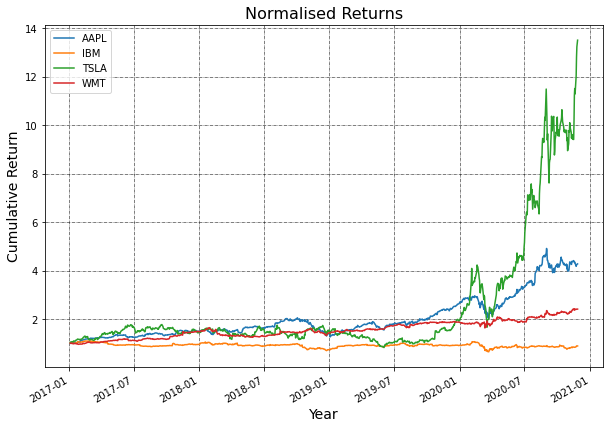

In [3]:
# Plot all the close prices
((data.pct_change()+1).cumprod()).plot(figsize=(10, 7))

# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("Normalised Returns", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Cumulative Return', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [4]:
def getTimelagDataset(data, lag=60): # takes a numpy array, returns time lagged training data
    X, y = [], []
    for i in range(lag, data.shape[0]):
        X.append(data[i-lag:i, 0])
        y.append(data[i, 0])
        
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1)) # one feature (price)
    
    return X, y

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data[["IBM"]])
X, y = getTimelagDataset(data)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

def LSTMmodel(): # model from Moghar et al.
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [7]:
model = LSTMmodel()

with tf.device('/device:GPU:0'):
    model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
    
    X_test = X[int(-0.2*X.shape[0]):]
    y_pred = model.predict(X_test)
    y_pred, y = scaler.inverse_transform(y_pred), scaler.inverse_transform(y.reshape(-1, 1))

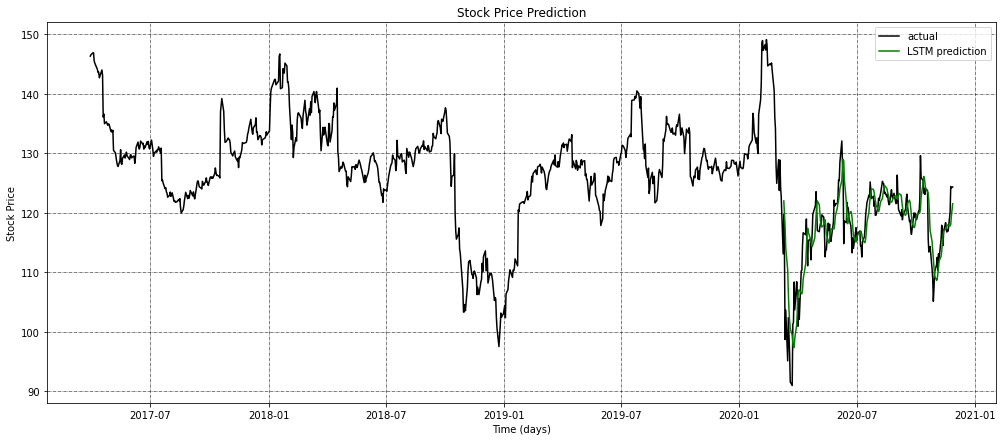

In [15]:
plt.plot(idx[-len(y):], y, color = 'black', label='actual')
plt.plot(idx[-len(y_pred):], y_pred, color='green', label='LSTM prediction')
plt.title('Stock Price Prediction')
plt.xlabel('Time (days)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

plt.gcf().set_size_inches(17, 7)
plt.show()